# (실습) 케라스와 텐서플로우

## 텐서플로우 활용

순수 텐서플로우 API만을 이용하여 두 개의 층을 갖는 선형 분류 신경망을 구현한다.

In [ ]:
import tensorflow as tf
import numpy as np

**데이터셋 생성**

- `np.random.multivariate_normal()`
    - 다변량 정규분포를 따르는 데이터 생성
    - 평균값과 공분산 지정 필요
- 음성 데이터셋
    - 샘플 수: 1,000
    - 평균값: `[0, 3]`
    - 공분산: `[[1, 0.5],[0.5, 1]]`
- 양성 데이터셋
    - 샘플 수: 1,000
    - 평균값: `[3, 0]`
    - 공분산: `[[1, 0.5],[0.5, 1]]`

In [ ]:
num_samples_per_class = 1000

# 음성 데이터셋
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

# 양성 데이터셋
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples_per_class)

두 개의 `(1000, 2)` 모양의 양성, 음성 데이터셋을 하나의 `(2000, 2)` 모양의 데이터셋으로 합치면서
동시에 자료형을 `np.float32`로 지정한다.
자료형을 지정하지 않으면 `np.float64`로 지정되어 보다 많은 메모리와 실행시간을 요구한다.

In [ ]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

음성 샘플의 타깃은 0, 양성 샘플의 타깃은 1로 지정한다.

In [ ]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

양성, 음성 샘플을 색깔로 구분하면 다음과 같다.

- `inputs[:, 0]`: x 좌표
- `inputs[:, 1]`: x 좌표
- `c=targets[:, 0]`: 0 또는 1에 따른 색상 지정

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

**모델 지정**

아래 `dense()` 함수는 밀집층(dense layer)에서의 아핀 변환을 담당한다.

In [ ]:
def dense(inputs, W, b, activation=None):
    outputs = tf.matmul(inputs, W) + b # input 매트릭스와 W 가중치 매트릭스를 곱하고 편향 b를 더한 것
    if activation != None:
        return activation(outputs)
    else:
        return outputs

두 개의 밀집층(dense layer)으로 구성된 순차 모델을 선언한다.

- 첫째 층: 유닛 5개
- 둘째 층: 유닛 1개

층을 구현하기 위해 먼저 각 층에 사용될 가중치 행렬과 편향 벡터를 초기화 한다.

- 첫째층의 가중치 행렬과 편향 벡터
    - 가중치 행렬: (2, 5) 모양의 텐서
    - 편향 벡터: (5,) 모양의 텐서

In [ ]:
input_dim1 = 2    # 입력 샘플의 특성수 2개
output_dim1 = 5   # 첫째층의 유닛수 5개

# 가중치: 균등분포를 이용한 무작위 초기화
W1 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim1, output_dim1)))

# 편향: 0으로 초기화
b1 = tf.Variable(initial_value=tf.zeros(shape=(output_dim1,)))

- 둘째층의 가중치 행렬과 편향 벡터
    - 가중치 행렬: (5, 1) 모양의 텐서
    - 편향 벡터: (1,) 모양의 텐서

In [ ]:
input_dim2 = 5    # 입력 샘플의 특성수 5개. 첫째층의 유닛수와 동일.
output_dim2 = 1   # 하나의 값 출력

# 가중치: 무작위 초기화
W2 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim2, output_dim2)))

# 편향: 0으로 초기화
b2 = tf.Variable(initial_value=tf.zeros(shape=(output_dim2,)))

이제 모델을 선언할 수 있다.

In [ ]:
def model(inputs):
    outputs = dense(inputs, W1, b1, tf.nn.relu) # 첫째 층 아핀 변환. relu 활성화 함수 사용
    outputs = dense(outputs, W2, b2)    # 둘째 층 아핀 변환
    return outputs

**손실 함수 선언**

손실값은 타깃과 예측값 사이의 오차의 제곱의 평균값으로 한다.

In [ ]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)
    return tf.reduce_mean(per_sample_losses)

**훈련 스텝**

하나의 배치에 대해 예측값을 계산한 후에 손실 함수의 그레이디언트를 이용하여 가중치와 편향을 업데이트한다.
배치를 전체 데이터셋으로 지정하기에 하나의 스텝은 하나의 에포크에 해당한다.

In [ ]:
learning_rate = 0.1

def training_step(inputs, targets):

    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)

    grad_loss_wrt_W1, grad_loss_wrt_b1, grad_loss_wrt_W2, grad_loss_wrt_b2 = tape.gradient(loss, [W1, b1, W2, b2])

    W1.assign_sub(grad_loss_wrt_W1 * learning_rate)
    b1.assign_sub(grad_loss_wrt_b1 * learning_rate)
    W2.assign_sub(grad_loss_wrt_W2 * learning_rate)
    b2.assign_sub(grad_loss_wrt_b2 * learning_rate)

    return loss

**훈련 실행**

총 100번의 에포크를 실행한다.
10번의 에포크마다 손실값을 출력하도록 하였다.

In [ ]:
for step in range(100): # 100번 step을 실행, step과 epoch가 동일하므로 "100번의 스텝"=="100번의 에포크"
    loss = training_step(inputs, targets)
    if step % 10 == 0:
        print(f"Loss at step {step}: {loss:.4f}")

손실값이 계속해서 줄어들고 있기에 훈련을 더 하는 게 좋다.
아래 코드는 1000번 더 반복 훈련한다.
가중치와 편향이 초기화되지 않고 이어서 업데이트됨에 주의한다.
손실값은 대신 100번 훈련할 때마다 출력되도록 하였다.

In [ ]:
for step in range(1001):
    loss = training_step(inputs, targets)
    if step % 100 == 0:
        print(f"Loss at step {step}: {loss:.4f}")

## 예측

In [ ]:
predictions = model(inputs)

예측 결과를 확인하면 다음과 같다.
예측값이 0.5보다 클 때 양성으로 판정한다.

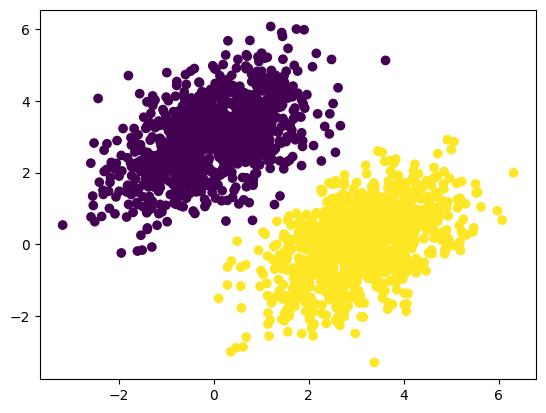

In [ ]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

##문제

###**문제 1** (오래걸림)

위 코드는 학습과정에서 전체 데이터셋을 하나의 배치로 사용한다.
배치 크기를 예를 들어 16, 32, 64, 128 등으로 지정하여
에포크가 여러 개의 스텝으로 구성되도록 코드를 수정한 후에 훈련을 진행하여 최선의 모델을 구현하라.

<Figure size 640x480 with 0 Axes>

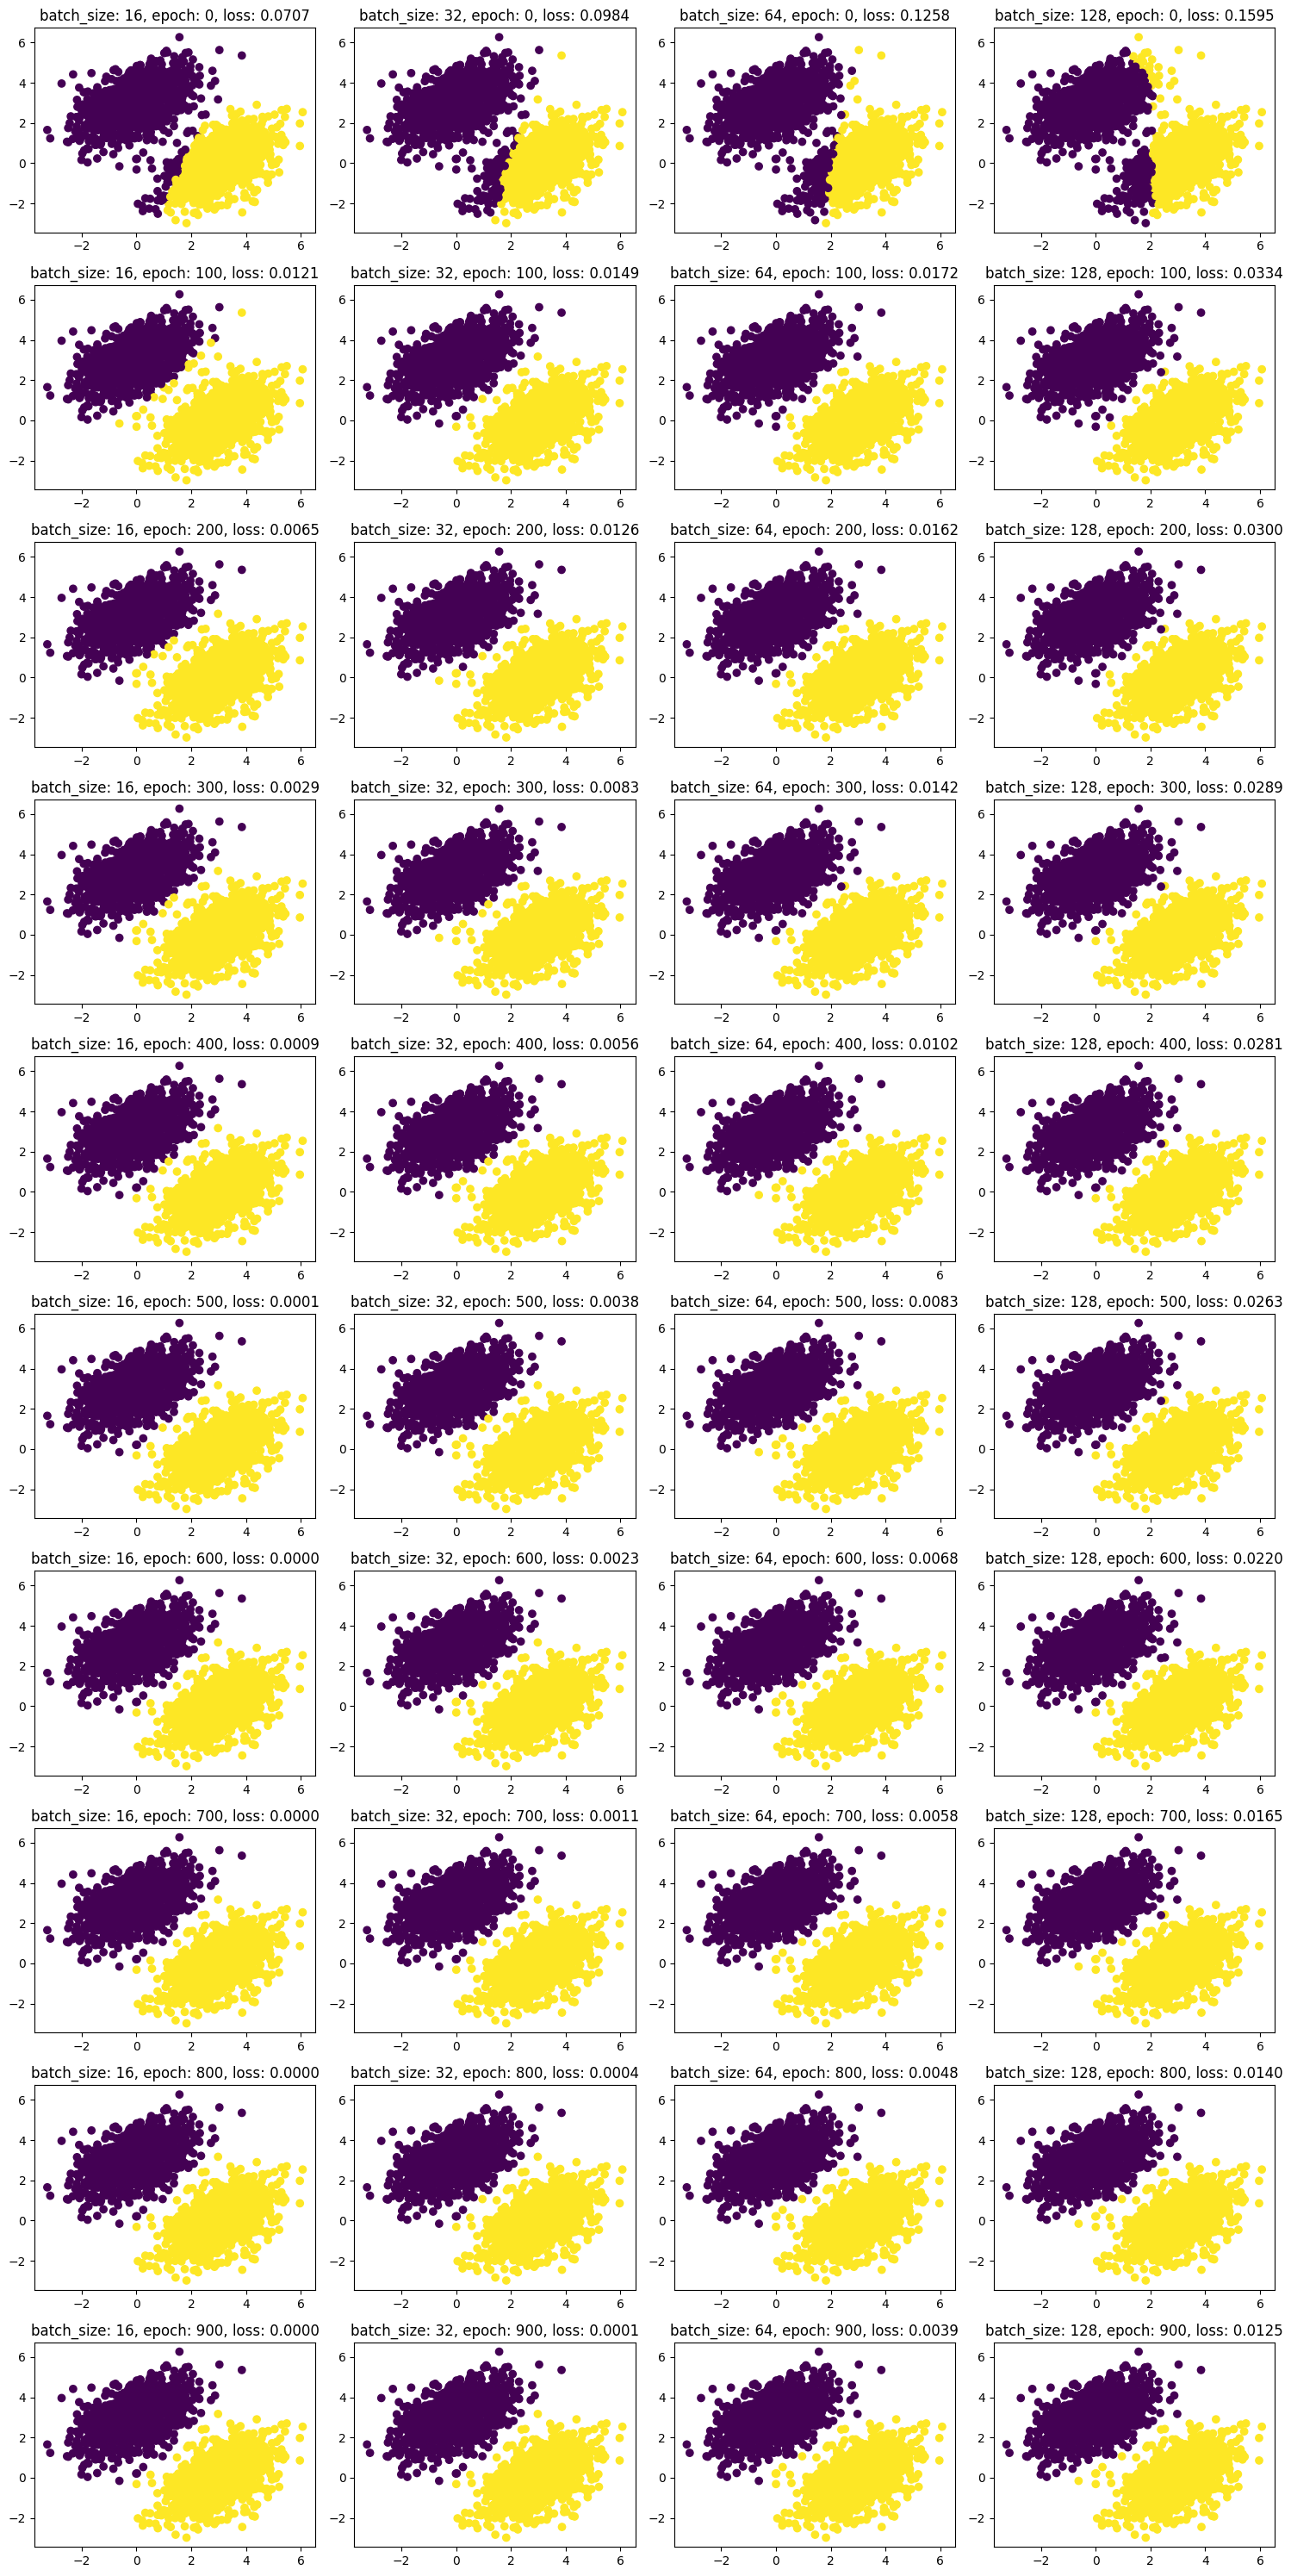

In [ ]:
input_dim1 = 2
output_dim1 = 5
input_dim2 = 5
output_dim2 = 1

learning_rate = 0.01 # 학습률 때문에 자꾸 발산하는 문제가 생겨 임의로 줄였다.

batch_size_list = [16,32,64,128]
num_epoch = 1000 # 총 몇 에포크 돌릴 건지
print_num = 100 # 몇 에포크마다 출력할지

plt.clf()
plt.figure(figsize=(15, 30))

num_rows = int(num_epoch/print_num)
num_cols = len(batch_size_list)

for i, batch_size in enumerate(batch_size_list):
  graph_num = 1+i

  tf.random.set_seed(0)# 파라미터 초기값 랜덤성 제거
  W1 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim1, output_dim1)))
  b1 = tf.Variable(initial_value=tf.zeros(shape=(output_dim1,)))
  W2 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim2, output_dim2)))
  b2 = tf.Variable(initial_value=tf.zeros(shape=(output_dim2,)))

  for epoch in range(num_epoch):
    for step_S in range(0, inputs.shape[0], batch_size):

      if step_S + batch_size < inputs.shape[0]:
        step_F = step_S + batch_size
      else:
        step_F = inputs.shape[0]

      loss = training_step(inputs[step_S: step_F, :], targets[step_S : step_F, :])

      if epoch+1 % print_num == 0 and step_F == inputs.shape[0]:
        plt.subplot(num_rows, num_cols, graph_num)
        graph_num += num_cols
        plt.title(f"batch_size: {batch_size}, epoch: {epoch+1}, loss: {loss:.4f}")
        predictions = model(inputs)
        plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

plt.tight_layout()
plt.show()

에포크와 학습률을 조정하며 다 회 돌려보았다.

####발생 했던 문제점
1. loss값의 일부가 Nan으로 반환되는 문제가 발생
 - 가정1 - 나누기 0으로 인해 반환된다. - 원인 step의 크기 조절에 실패했다. (이상없음)
 - 가정2 - 루트 0으로 인해 반환된다. - (원인없음)
 - 가정3 - inf 값으로 인해 반환된다. - loss값을 1에포크 간격으로 출력 해본 결과 중간에 아주 큰 값이 1~2개 반환되다 NAN으로 넘어갔다.


 - 발산이라고 가정하고 발산하는 원인을 생각해 보았을 때, 학습률이 너무 큰 문제가 원인이였다.


---

####결과 해석
1. 배치 사이즈가 작으면, 적은 에포크 수로 빠르게 학습한다. 하지만 역전파의 실행이 많아 오래 걸린다.

2. 배치 사이즈가 크면, 학습에 많은 에포크 수가 필요하다. 역전파의 실행이 많지 않다.

3. 학습률이 크면 발산 할 수 있고, 학습이 빠르지만 특정 오차에서 진동하며 감소하지 않는다.

4. 학습률이 작으면 학습이 느리지만 확실하게 오차를 잡아냈다.

5. 작은 학습률을 사용하면 학습에 걸리는 시간이 오래 걸리지만 결국 오차를 잡아낸다.

---

####추가 리서치
1. 컴퓨터가 이진으로 작동하기 떄문에 2,4,8,16등 2의 n승을 배치크기로 사용하는게 빠르다. 또한 GPU의 크기에 맞추는 것이 가장 빠른 속도를 보인다고 한다.
https://ai.stackexchange.com/questions/8560/how-do-i-choose-the-optimal-batch-size


2. 작은 배치 크기는 훈련셋의 과대적합이 쉽다. 큰 배치 크기가 좋은 일반화 성능을 가진다. 하지만 정확도가 떨어진다는 단점이 있다. 이 실험에서는 32의 배치크기가 가장 성능이 좋았다고 한다.
https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU

---

####결론
배치크기는 과도하게 큰 배치에서 나타나는 성능저하, 작은 배치크기에서 역전파로 일어나는 실행 시간의 문제가 있다. 따라서 중간 배치크기를 사용하는 것이 좋다.

리서치에서 나온 32의 배치 크기를 사용한다. 학습률은 이 문제에서 다루는 주요 주제가 아니므로 배제 하도록 한다.

최선의 배치크기와 에포크를 가진 모델

In [ ]:
tf.random.set_seed(0)# 파라미터 초기값 랜덤성 제거
W1 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim1, output_dim1)))
b1 = tf.Variable(initial_value=tf.zeros(shape=(output_dim1,)))
W2 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim2, output_dim2)))
b2 = tf.Variable(initial_value=tf.zeros(shape=(output_dim2,)))

learning_rate = 0.01
batch_size = 32 # batch size
epoch = 1000
DTST_SIZE = inputs.shape[0] # dataset size

for e in range(1,epoch+1):
  for step_start in range(0, DTST_SIZE, batch_size):

    if step_start + batch_size < DTST_SIZE:
      step_final = step_start + batch_size

    else:
      step_final = DTST_SIZE


    loss = training_step(inputs[step_start: step_final, :], targets[step_start : step_final, :])
    if e % 100 == 0 and step_final == DTST_SIZE:
      print(f"epoch: {e}, loss: {loss:.4f}")

epoch: 100, loss: 0.0149
epoch: 200, loss: 0.0128
epoch: 300, loss: 0.0083
epoch: 400, loss: 0.0056
epoch: 500, loss: 0.0038
epoch: 600, loss: 0.0023
epoch: 700, loss: 0.0011
epoch: 800, loss: 0.0004
epoch: 900, loss: 0.0001
epoch: 1000, loss: 0.0000


###**문제 2**

예측 정확도(accuracy)를 평가지표(`metrics`)로 지정하여 훈련 에포크마다 손실값과 함께 출력하는 기능을 추가하라.
단, 예측값이 0.5 이상이면 양성, 아니면 음성으로 판정하며,
에포크의 손실값과 정확도는 스텝별로 계산된 손실값과 정확도의 평균값을 사용한다.

In [ ]:
def training_step(inputs, targets):

    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)

    # acuuracy를 구하는 부분
    accuracy = list(predictions.numpy().round()==targets).count(True)

    grad_loss_wrt_W1, grad_loss_wrt_b1, grad_loss_wrt_W2, grad_loss_wrt_b2 = tape.gradient(loss, [W1, b1, W2, b2])

    W1.assign_sub(grad_loss_wrt_W1 * learning_rate)
    b1.assign_sub(grad_loss_wrt_b1 * learning_rate)
    W2.assign_sub(grad_loss_wrt_W2 * learning_rate)
    b2.assign_sub(grad_loss_wrt_b2 * learning_rate)

    return loss, accuracy

In [ ]:
tf.random.set_seed(0)# 파라미터 초기값 랜덤성 제거
W1 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim1, output_dim1)))
b1 = tf.Variable(initial_value=tf.zeros(shape=(output_dim1,)))
W2 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim2, output_dim2)))
b2 = tf.Variable(initial_value=tf.zeros(shape=(output_dim2,)))

learning_rate = 0.01

batch_size = 32 # batch size
epoch = 100
DTST_SIZE = inputs.shape[0] # dataset size

for e in range(1,epoch+1):
  epoch_accuracy = 0
  epoch_loss = 0
  for step_start in range(0, DTST_SIZE, batch_size): # step 반복문

    if step_start + batch_size < DTST_SIZE:
      step_final = step_start + batch_size

    else:
      step_final = DTST_SIZE

    step_loss, step_accuracy = training_step(inputs[step_start: step_final, :], targets[step_start : step_final, :])

    step_size = step_final - step_start
    epoch_accuracy += step_accuracy # step_accuracy는 True의 개수를 넘겨 받는다.
    epoch_loss += step_loss * step_size # step_loss는 0과 1 사이의 손실값을 넘겨 받는다.

    if e % 10 == 0 and step_final == DTST_SIZE:
      print(f"Loss at epoch {e}: {epoch_loss/DTST_SIZE:.4f} - accuracy {epoch_accuracy/DTST_SIZE}")

Loss at epoch 10: 0.0249 - accuracy 0.992
Loss at epoch 20: 0.0215 - accuracy 0.997
Loss at epoch 30: 0.0198 - accuracy 0.9985
Loss at epoch 40: 0.0188 - accuracy 0.999
Loss at epoch 50: 0.0183 - accuracy 0.9995
Loss at epoch 60: 0.0180 - accuracy 0.9995
Loss at epoch 70: 0.0179 - accuracy 0.9995
Loss at epoch 80: 0.0178 - accuracy 0.9995
Loss at epoch 90: 0.0177 - accuracy 0.9995
Loss at epoch 100: 0.0176 - accuracy 0.9995


###**문제 3**

위 코드는 두 개의 `dense` 층을 사용한다.
세 개의 `dense` 층을 사용하도록 모델을 지정하고 훈련시키는 과정을 구현하라.

힌트:

- `model` 선언과 `training_step()` 함수 선언에서 수정이 요구된다.
- 마지막 출력층을 제외한 두 개의 은닉층은 `relu()` 활성화 함수를 사용한다.

In [ ]:
input_dim1 = 2    # 입력 샘플의 특성수 2개
output_dim1 = 5   # 첫째층의 유닛수 5개
W1 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim1, output_dim1)))
b1 = tf.Variable(initial_value=tf.zeros(shape=(output_dim1,)))

In [ ]:
output_dim2 = 2   # 2개의 값 출력
W2 = tf.Variable(initial_value=tf.random.uniform(shape=(output_dim1, output_dim2)))
b2 = tf.Variable(initial_value=tf.zeros(shape=(output_dim2,)))

In [ ]:
output_dim3 = 1   # 하나의 값 출력
W3 = tf.Variable(initial_value=tf.random.uniform(shape=(output_dim2, output_dim3)))
b3 = tf.Variable(initial_value=tf.zeros(shape=(output_dim3,)))

In [ ]:
def model(inputs):
    outputs = dense(inputs, W1, b1, tf.nn.relu)
    outputs = dense(outputs, W2, b2, tf.nn.relu)
    outputs = dense(outputs, W3, b3)
    return outputs

In [ ]:
learning_rate = 0.01

def training_step(inputs, targets):

    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(predictions, targets)

    grad_loss_wrt_W1, grad_loss_wrt_b1, grad_loss_wrt_W2, grad_loss_wrt_b2, grad_loss_wrt_W3, grad_loss_wrt_b3 = tape.gradient(loss, [W1, b1, W2, b2, W3, b3])

    W1.assign_sub(grad_loss_wrt_W1 * learning_rate)
    b1.assign_sub(grad_loss_wrt_b1 * learning_rate)
    W2.assign_sub(grad_loss_wrt_W2 * learning_rate)
    b2.assign_sub(grad_loss_wrt_b2 * learning_rate)
    W3.assign_sub(grad_loss_wrt_W3 * learning_rate)
    b3.assign_sub(grad_loss_wrt_b3 * learning_rate)

    return loss

In [ ]:
batch_size = 32 # batch size
epoch = 100
DTST_SIZE = inputs.shape[0] # dataset size

for e in range(1,epoch+1):
  for step_start in range(0, DTST_SIZE, batch_size): # step 반복문

    if step_start + batch_size < DTST_SIZE:
      step_final = step_start + batch_size

    else:
      step_final = DTST_SIZE

    loss = training_step(inputs[step_start: step_final, :], targets[step_start : step_final, :])

    if e % 10 == 0 and step_final == DTST_SIZE:
      print(f"Loss at epoch {e}: {loss:.4f}")

Loss at epoch 10: 0.0467
Loss at epoch 20: 0.0266
Loss at epoch 30: 0.0263
Loss at epoch 40: 0.0261
Loss at epoch 50: 0.0258
Loss at epoch 60: 0.0256
Loss at epoch 70: 0.0253
Loss at epoch 80: 0.0249
Loss at epoch 90: 0.0245
Loss at epoch 100: 0.0241


###**문제 4**(오래걸림)

세 개의 `dense` 층을 사용했을 때 마지막 층을 제외한 두 개의 은닉층에서의 유닛 개수를 몇 개로 지정할 때
최적의 모델을 구현할 수 있는지 확인하라.

<Figure size 640x480 with 0 Axes>

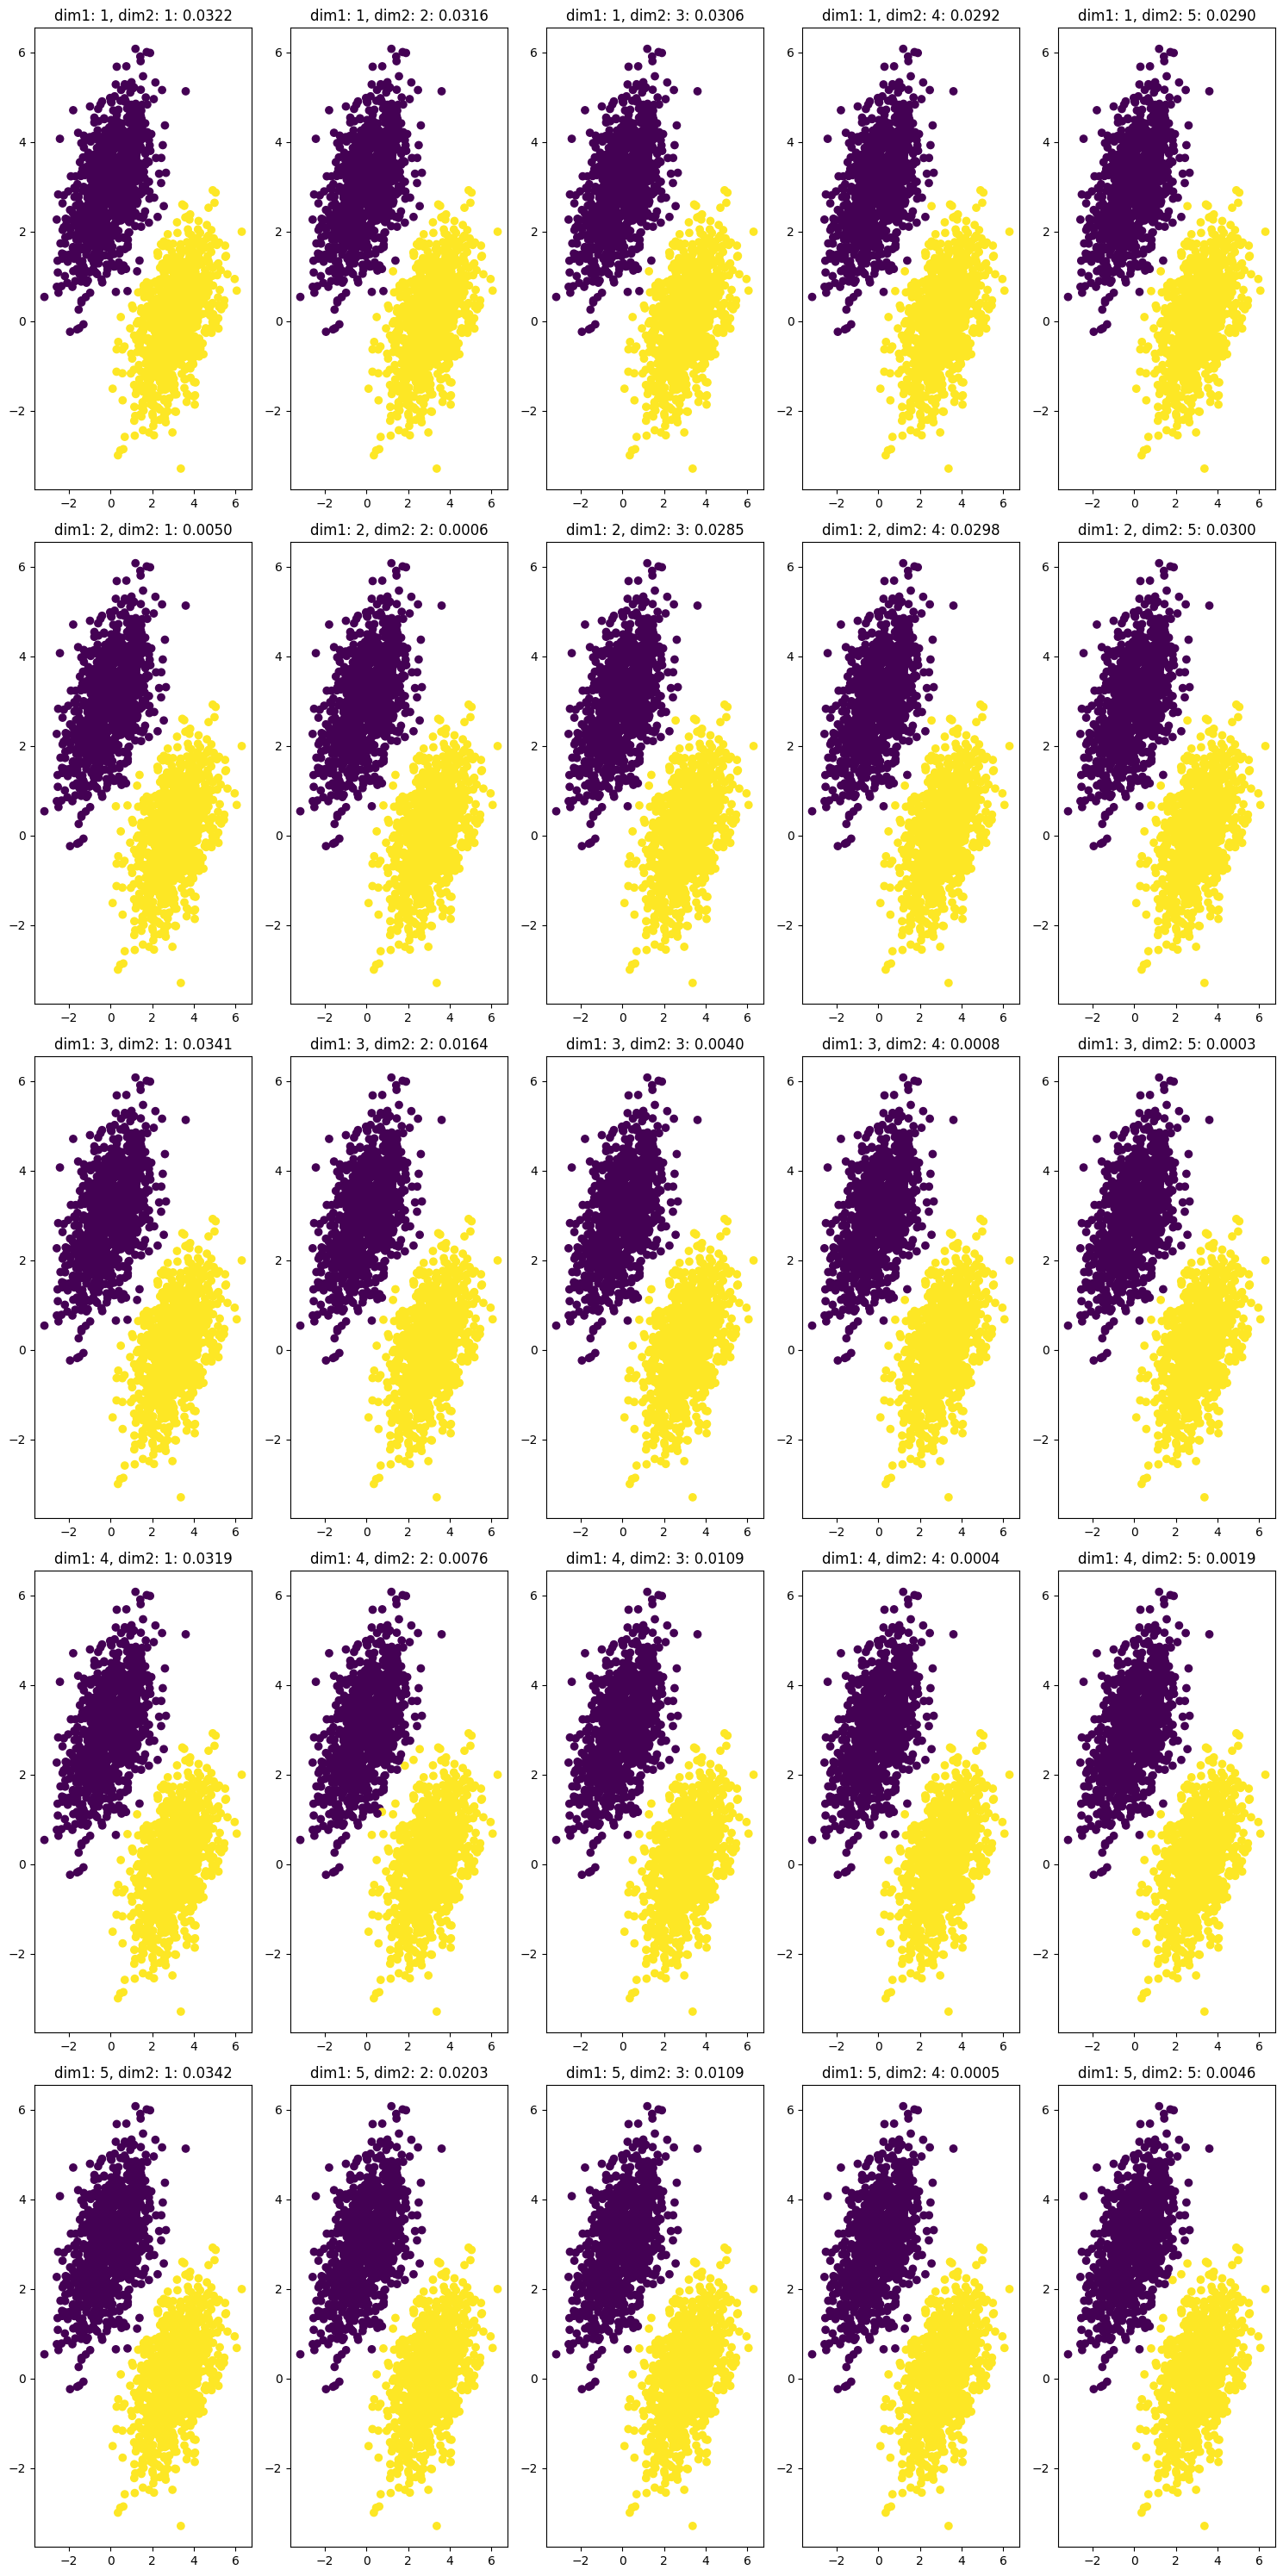

In [ ]:
input_dim1 = 2    # 입력 샘플의 특성수 2개
output_dim3 = 1   # 최종 하나의 값 출력

learning_rate = 0.01
batch_size = 32 # batch size
epoch = 100
DTST_SIZE = inputs.shape[0] # dataset size

plt.clf()
plt.figure(figsize=(15, 30))
dim1_num = 5
dim2_num = 5
plt_num = 1
for output_dim1 in range(1,dim1_num+1):
  for output_dim2 in range(1,dim2_num+1):
    tf.random.set_seed(0)# 파라미터 초기값 랜덤성 제거
    W1 = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim1, output_dim1)))
    b1 = tf.Variable(initial_value=tf.zeros(shape=(output_dim1,)))
    W2 = tf.Variable(initial_value=tf.random.uniform(shape=(output_dim1, output_dim2)))
    b2 = tf.Variable(initial_value=tf.zeros(shape=(output_dim2,)))
    W3 = tf.Variable(initial_value=tf.random.uniform(shape=(output_dim2, output_dim3)))
    b3 = tf.Variable(initial_value=tf.zeros(shape=(output_dim3,)))
    for e in range(1,epoch+1):
      for step_start in range(0, DTST_SIZE, batch_size):
        loss = training_step(inputs, targets)
        if step_start + batch_size < DTST_SIZE:
          step_final = step_start + batch_size
        else:
          step_final = DTST_SIZE
        loss = training_step(inputs[step_start: step_final, :], targets[step_start : step_final, :])
    plt.subplot(dim1_num, dim2_num, plt_num)
    plt_num+=1
    plt.title(f"dim1: {output_dim1}, dim2: {output_dim2}: {loss:.4f}")
    predictions = model(inputs)
    plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.tight_layout()
plt.show()

1번문제의 가장 좋은 모델과 비교하고

위의 분포도와 데이터를 보았을 때

1번 은닉층 3개의 유닛

2번 은닉층 5개의 유닛

이 가장 점수가 좋았다.

## [TensorFlow Playground](https://playground.tensorflow.org)

[TensorFlow Playground](https://playground.tensorflow.org)에서 분류와 회귀 모델의 학습과정을 살펴 보면서
문제를 해결하는 최선의 모델을 찾고자 한다.
그런 다음에 아래 요소들에 적절한 값이 선택된 이유를 (추정해서) 설명할 수 있어야 한다.

- 특성(features) 선택
- 학습률(learning rate)
- 활성화 함수(activation function)
- 규제(regularization)와 규제율(regularization rate)
- 훈련셋(training set)대 테스트셋(test set) 비율
- 배치 크기(batch size)
- 은닉층(hidden layer)과 유닛(unit 또는 neuron) 수

**모델 A**

아래 그림은 음성 데이터(주황색)와 양성 데이터(파랑색)를 분류하는 목적으로 훈련 시키려 하는 심층 신경망 모델을 보여준다.

- 입력 특성: $\mathrm{x}_1$과 $\mathrm{x}_2$ 두 개
- 은닉층(hidden layer) 2개
    - 첫째 은닉층: 유닛 4개
    - 둘째 은닉층: 유닛 2개
- 출력값 1개: 양성/음성 여부 판단
    
유닛과 유닛을 연결하는 파란선/주황선은 각각 양의 가중치와 음의 가중치 값을 가리킨다.
선의 두께는 가중치의 절댓값에 해당한다.
즉, 두꺼운 선일 수록 해당 가중치가 출력 유닛에 저장되는 값을 계산할 때 기여도가 보다 크다.


<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a07.jpg" style="width:700px;"></div>


위 사진의 모델을 훈련시키면 다음과 같이 결과가 나온다.

- 훈련 에포크: 505
- 학습률: 0.03
- 층에 사용되는 활성화 함수: Tanh
- 평가 지표
    - 테스트셋에 대한 손실값: 0.003
    - 훈련셋에 대한 손실값: 0.001



<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a05.png" style="width:700px;"></div>


**모델 B**

반면에 하나의 은닉층만 사용하면 결과가 다르게 나온다.

- 은닉층(hidden layer) 1개
    - 첫째 은닉층: 유닛 4개
- 훈련 에포크: 511
- 학습률: 0.03
- 층에 사용되는 활성화 함수: Tanh
- 평가 지표
    - 테스트셋에 대한 손실값: 0.016
    - 훈련셋에 대한 손실값: 0.004

즉, 훈련된 모델의 성능(평가지표)가 두 개의 은닉층을 사용하는 모델보다 나쁘다.
특히 테스트셋에 대한 성능이 훈련셋에 대한 성능보다 많이 떨어져서
과대적합(overfitting)이 보다 심하게 발생했다.


<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a04.png" style="width:700px;"></div>


**모델 C**

은닉층을 아래 그림에서처럼 세 개로 늘리면 성능이 두 개의 은닉층을 사용할 때보다 성능이 좀 더 좋아진다.

- 은닉층(hidden layer) 3개
    - 첫째 은닉층: 유닛 4개
    - 둘째 은닉층: 유닛 3개
    - 둘째 은닉층: 유닛 2개
- 훈련 에포크: 234
- 학습률: 0.03
- 층에 사용되는 활성화 함수: Tanh
- 평가 지표
    - 테스트셋에 대한 손실값: 0.001
    - 훈련셋에 대한 손실값: 0.001

에포크가 234로 이전보다 훨씬 빠르게 좋은 분류 모델을 학습시킨다.
은닉층을 늘린다고 무조건 좋아지는 것은 일반적으로 아니지만 이 경우엔 최선의 결과를 낳았다.


<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/dlp2/master/jupyter-book/imgs/ch03-tf-playground-a06.png" style="width:700px;"></div>


## 케라스 활용

케라스를 이용하여 앞서 소개한 모델 A, 모델 B, 모델 C를 직접 구성해서
훈련시키고자 한다.
훈련에 사용되는 데이터셋은 아래 코드를 이용하여 생성한다.

In [ ]:
import tensorflow as tf
import numpy as np
import sklearn
import matplotlib.pyplot as plt

[`make_circles()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html) 함수를 이용하여 모델 학습에 사용될 데이터셋을 생성한다.

- `datasets`: 입력 데이터셋. (2000, 2) 모양의 텐서. 2000개의 데이터 샘플 포함. 양성, 음성 각각 1000개
- `targets`: 타깃 데이터셋. 0과 1로 구성된 (2000,) 모양의 텐서. 0은 음성, 1은 양성.

In [ ]:
from sklearn.datasets import make_circles
dataset, targets = make_circles(2000, noise=0.1, factor=0.2)

`dataset`은 (2000, 2) 모양의 텐서다.
즉, 한 개의 데이터 샘플은 두 개의 특성을 갖는다.

In [ ]:
print("모양: ", dataset.shape)
print("첫 5개 데이터:", dataset[:5], sep='\n')

모양:  (2000, 2)
첫 5개 데이터:
[[ 0.09808617 -0.20666428]
 [ 0.06461878 -0.14720561]
 [ 0.21397577  0.02478798]
 [-0.93498724  0.22705973]
 [-0.88348555 -0.30116498]]


2000개의 샘플의 양성/음성 여부는 (2000, 1) 모양의 `targets` 텐서에 저장되어 있으며
무작위로 지정되어 있다.
예를 들어 첫 5개 샘플의 양성/음성 여부는 다음과 같다.
0은 음성을, 1은 양성을 가리킨다.

In [ ]:
print("타겟 모양: ", targets.shape)
print("타겟:", targets[:5], sep='\n')

타겟 모양:  (2000,)
타겟:
[1 1 1 0 0]


양성은 파란색, 음성은 주황색으로 표시한 데이터 산점도는 다음과 같다.

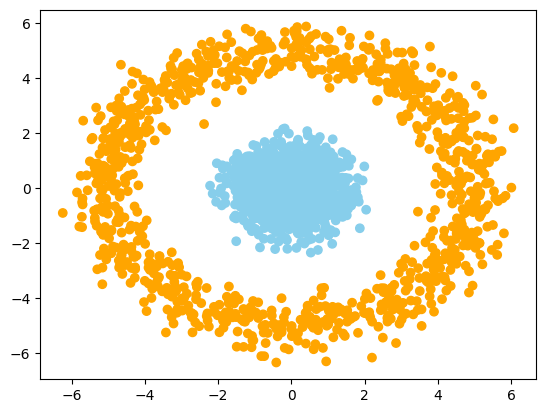

In [ ]:

plt.scatter(dataset[:,0]*5, dataset[:,1]*5, c=['orange' if i==0 else 'skyblue' for i in targets])
plt.show()

케라스를 이용하여 "모델 A"를 구성한 다음에 위 데이터셋을 이용하여 훈련시키고자 한다.
먼저, `targets`의 모양을 다음과 같이 변환시킨다.
이유는 케라스 모델은 타깃 데이터셋도 2차원 텐서를 요구하기 때문이다.

신경망 모델은 데이터 샘플 별로 여러 종류의 값을 동시에 예측할 수 있기에
하나의 샘플에 대한 예측값을 종류별 예측값으로 구성된 벡터로 계산한다.
여기서는 데이터 샘플 별로 양성/음성 여부에 대해서만 예측하기 때문에
한 샘플에 대한 예측값은 길이가 1인 벡터이다.
따라서 타깃셋은 (2000, 1) 모양의 텐서이어야 한다.

In [ ]:
targets = targets.reshape(-1,1)
targets

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

모델 A를 신경망 모델 `model_A`로 구성하면 다음과 같다.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model_A = keras.Sequential([
    layers.Dense(4, activation="tanh"),   # 첫째 은닉층
    layers.Dense(2, activation="tanh"),   # 둘째 은닉층
    layers.Dense(1, activation="sigmoid") # 출력층
    ])

`model_A` 를 아래 옵션을 이용하여 컴파일한다.

- 옵티마이저: `rmsprop`
- 손실: `binary_crossentropy` (이진 분류 용도의 손실 함수 지정)
- 평가지표: `accuracy` (정확도 평가)

In [ ]:
model_A.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

50대 50의 비율로 훈련용 데이터셋과 타깃셋인 `x_train`, `y_train`과
테스트용 데이터셋과 타깃셋 `x_test`, `y_test`를 지정한다.

In [ ]:
x_train, y_train = dataset[:1000], targets[:1000]
x_test, y_test = dataset[1000:], targets[1000:]

모델을 훈련시킨다.
`fit()` 메서드의 반환값은 훈련이 잘 된 모델의 정보를 담고 있는 `History` 객체이다.

In [ ]:
history = model_A.fit(x_train, y_train, epochs=30, batch_size=10)

Epoch 1/30
100/100 [==============================] - 1s 4ms/step - loss: 0.6919 - accuracy: 0.6550
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.6851 - accuracy: 0.7220
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.7090
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.6703 - accuracy: 0.7100
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.6611 - accuracy: 0.7030
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.6514 - accuracy: 0.7100
Epoch 7/30
100/100 [==============================] - 0s 2ms/step - loss: 0.6407 - accuracy: 0.7430
Epoch 8/30
100/100 [==============================] - 0s 2ms/step - loss: 0.6292 - accuracy: 0.7850
Epoch 9/30
100/100 [==============================] - 0s 2ms/step - loss: 0.6170 - accuracy: 0.7970
Epoch 10/30
100/100 [==============================] - 0s 2ms/step - loss: 0.6044 - accuracy: 0.8060

`History` 객체는 훈련된 모델의 다양한 정보를 저장한다.
예를 들어 `model` 속성은 훈련된 모델을 저장한다.
아래 코드는 훈련된 모델이 `Sequential` 모델임을 확인해준다.

In [ ]:
type(history.model)

keras.src.engine.sequential.Sequential

케라스의 모든 모델은 `keras.Model` 클래스를 상속한다.

In [ ]:
isinstance(history.model, keras.Model)

True

따라서 모델에 사용된 층의 구성을 확인기 위해
`Model` 클래스의 인스턴스 메서드인 `summary()` 메서드를 이용할 수 있다.

In [ ]:
history.model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_55 (Dense)            (10, 4)                   12        
                                                                 
 dense_56 (Dense)            (10, 2)                   10        
                                                                 
 dense_57 (Dense)            (10, 1)                   3         
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


위 결과가 설명하는 바는 다음과 같다.

- `Layer (type)` 열: 각 층에 사용된 층의 이름과 종류. 이름을 별도로 지정하지 않으면 자동으로 지정된다.
- `Output Shape` 열: 각 층에서 생성되는 출력 텐서의 모양.
    예를 들어 (10, 4)에서 10은 배치 크기를, 4는 네 개의 유닛 개수. 즉 원래 2개의 특성을 갖는 데이터 샘플 각각을
    4개의 특성을 갖는 데이터 샘플로 변환.
- `Param`: 각 층에서 학습되는 파라미터(가중치와 편향)의 개수. 계산법은 다음과 같음.
    - 첫째 층의 파라미터: `2*4 + 4 = 12`
    - 둘째 층의 파라미터: `4*2 + 2 = 10`
    - 셋째 층의 파라미터: `2*1 + 1 = 3`

기타 요소는 다음과 같다.

- `Toral params`: 파라미터 수의 총합. `12 + 10 + 3 = 25`
- `Trainable params`: 훈련되는 파라미터 수의 총합. `12 + 10 + 3 = 25`
- `Non-trainable params`: 훈련되지 않는 파라미터 수의 총합. `0 + 0 + 0 = 0`.
    즉, 위 모델은 훈련되지 않는 파라미터 사용하지 않음.


`history.model`이 가리키는 모델과 `model_A` 동일한 모델을 가리킨다.
이유는 `model_A.fit()` 메서드가 실행되는 동안 `model_A`가 훈련되는데,
이는 지정된 가중치 행렬과 편향 벡터가 모델 자체에서 업데이트 되는 것을 의미하기 때문이다.

실제로 테스테셋의 처음 5개 데이터 샘플에 대한 예측값이 동일함을 아래 코드로 확인할 수 있다.

In [ ]:
model_A.predict(x_test[:5])

1/1 [==============================] - 0s 96ms/step


array([[0.22229126],
       [0.73114526],
       [0.65777665],
       [0.1987091 ],
       [0.78391355]], dtype=float32)

In [ ]:
history.model.predict(x_test[:5])

1/1 [==============================] - 0s 27ms/step


array([[0.22229126],
       [0.73114526],
       [0.65777665],
       [0.1987091 ],
       [0.78391355]], dtype=float32)

`History` 객체의 `params` 인스턴스 속성은 `fit()` 메서드가 모델 훈련에 사용되는
하이퍼파라미터를 저장한다.
아래 코드는 30번의 에포크와 스텝의 수를 보여준다.
참고로 스텝은 훈련셋의 크기와 배치크기에 의해 자동 결정된다.
여기서 100인 이유는 훈련셋의 크기가 1000이고 배치 크기가 10 기에
총 `1000/10 = 100` 번의 스텝이 한 번의 에포크 동안 실행된다.
`verbose`는 모델 훈련 과정중에 에포크별로 진행상황과 평가 결과를 어떻게 보여줄 것인가를 지정한다.
별 이유가 없다면 기본값을 굳이 바꿀 필요는 없다.

In [ ]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 100}

`History` 객체의 `history` 속성은 훈련 과정에서 에포크 단위로 계산된
훈련셋과 검증셋에 대한 손실값(loss)과 평가지표를 저장한 사전 객체를 가리킨다.
여기서는 검증셋은 지정되지 않았고, 평가지표로 정확도(accuracy) 하나만 사용하였기에
훈련셋에 대한 손실값(loss)과 정확도(accuracy)만 에포크 단위로 저장한다.

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

예를 들어 에포크 별 훈련셋에 대한 손실값의 변화는 다음과 같다.

In [ ]:
history.history['loss']

[0.6919485330581665,
 0.6850761771202087,
 0.678253173828125,
 0.67027348279953,
 0.6611190438270569,
 0.6514345407485962,
 0.6407374143600464,
 0.6291967630386353,
 0.6170408725738525,
 0.6043799519538879,
 0.5914760231971741,
 0.5792340040206909,
 0.5681726932525635,
 0.5564506649971008,
 0.5447354316711426,
 0.5334571003913879,
 0.522264838218689,
 0.51219242811203,
 0.5019723176956177,
 0.4920462369918823,
 0.48319530487060547,
 0.474796324968338,
 0.46632087230682373,
 0.45873042941093445,
 0.45105528831481934,
 0.44381341338157654,
 0.4371349811553955,
 0.43065303564071655,
 0.4244157373905182,
 0.4185087978839874]

에포크 별 훈련셋에 대한 정확도의 변화는 다음과 같다.

In [ ]:
history.history['accuracy']

[0.6549999713897705,
 0.722000002861023,
 0.7089999914169312,
 0.7099999785423279,
 0.703000009059906,
 0.7099999785423279,
 0.7429999709129333,
 0.7850000262260437,
 0.796999990940094,
 0.8059999942779541,
 0.8190000057220459,
 0.8180000185966492,
 0.8339999914169312,
 0.8360000252723694,
 0.8450000286102295,
 0.8550000190734863,
 0.8539999723434448,
 0.8640000224113464,
 0.8629999756813049,
 0.8690000176429749,
 0.8730000257492065,
 0.8700000047683716,
 0.8740000128746033,
 0.871999979019165,
 0.875,
 0.8790000081062317,
 0.8769999742507935,
 0.8799999952316284,
 0.8799999952316284,
 0.8820000290870667]

##**문제 1**

모델 B를 신경망 모델 `model_B`로 구성한 다음 훈련시킨 결과를 설명하라.

In [ ]:
model_B = keras.Sequential([
    layers.Dense(4, activation="tanh"),   # 첫째 은닉층 4개의 유닛
    layers.Dense(1, activation="sigmoid") # 출력층
    ])

In [ ]:
model_B.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model_B.fit(x_train, y_train, epochs=30, batch_size=10,) # model_B 511개의 에포크 배치사이즈
# 임의로 에포크를 30으로 줄였다.

##**문제 2**

모델 C를 신경망 모델 `model_C`로 구성한 다음 훈련시킨 결과를 설명하라.

In [ ]:
model_C = keras.Sequential([
    layers.Dense(4, activation="tanh"),   # 1번 은닉층 4개의 유닛
    layers.Dense(3, activation="tanh"),   # 2번 은닉층 3개의 유닛
    layers.Dense(2, activation="tanh"),   # 3번 은닉층 2개의 유닛
    layers.Dense(1, activation="sigmoid") # 출력층
    ])

In [ ]:
model_C.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
history = model_C.fit(x_train, y_train, epochs=30, batch_size=10) # model_C 에포크 234 배치 사이즈 10
# 임의로 에포크의 사이즈를 30으로 줄였다.

##**문제 3**

`model_A`, `model_B`, `model_C`의 성능을 비교하라.

In [ ]:
np.unique(model_A.predict(x_test).round()==y_test,return_counts=True)

32/32 [==============================] - 0s 2ms/step


(array([False,  True]), array([132, 868]))

In [ ]:
np.unique(model_B.predict(x_test).round()==y_test,return_counts=True)

32/32 [==============================] - 0s 2ms/step


(array([False,  True]), array([133, 867]))

In [ ]:
np.unique(model_C.predict(x_test).round()==y_test,return_counts=True)

32/32 [==============================] - 0s 2ms/step


(array([ True]), array([1000]))

model_A가 가 30 에포크에서 가장 성능이 좋다.

##**문제 4**

아래 설정을 변경하면서 최고 성능의 모델을 구현하라.

- 층과 유닛의 개수
- 훈련셋과 테스트셋의 비율
- 배치 크기
- 학습률
- 규제와 규제율
- 활성화 함수
- 에포크

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import to_categorical

# 데이터 전처리
X_train, X_test, y_train, y_test = train_test_split(dataset, targets, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 원-핫 인코딩을 사용하여 레이블을 변환해 분류문제로 바꾼다.
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# 모델 생성
model = Sequential()
model.add(Dense(128, input_dim=2, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# 모델 훈련
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

Epoch 1/100
50/50 [==============================] - 1s 8ms/step - loss: 0.5396 - accuracy: 0.6062 - val_loss: 0.3892 - val_accuracy: 0.9075
Epoch 2/100
50/50 [==============================] - 0s 4ms/step - loss: 0.2948 - accuracy: 0.9438 - val_loss: 0.1299 - val_accuracy: 1.0000
Epoch 3/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0796 - accuracy: 0.9925 - val_loss: 0.0134 - val_accuracy: 1.0000
Epoch 4/100
50/50 [==============================] - 0s 4ms/step - loss: 0.0246 - accuracy: 0.9969 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 5/100
50/50 [==============================] - 0s 3ms/step - loss: 0.0125 - accuracy: 0.9981 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 6/100
50/50 [==============================] - 0s 3ms/step - loss: 0.0095 - accuracy: 0.9981 - val_loss: 6.6382e-04 - val_accuracy: 1.0000
Epoch 7/100
50/50 [==============================] - 0s 3ms/step - loss: 0.0058 - accuracy: 0.9994 - val_loss: 5.4151e-04 - val_accuracy: 1.0000
Epoch

## 캘리포니아 주택가격 데이터셋

**문제 1**

캘리포니아 주택가격 데이터셋을 이용한 회귀 심층 신경망 모델을 구성하고 훈련시켜라.
단, `Sequential` 모델과 `Dense` 층 이외에 다른 종류의 모델과 층은 절대로 이용하지 않는다.
또한 캘리포니아 데이터셋과 모델 구성에 대해서는 인터넷 자료를 참고하며,
모델을 구성할 때 다음 사항에 주의한다.

- 회귀 모델의 마지막 출력층은 활성화 함수를 사용하지 않는다.
- 모델 컴파일 요소(옵티마이저, 손실 함수, 평가지표) 또한 인터넷 자료를 참고한다.
- 은닉층의 활성화 함수는 `relu` 함수를 이용한다.


힌트: 아래 사이트를 참고한다.

- https://www.kaggle.com/code/saurav9786/ann-with-tensorflow-2-0-to-predict-housing-prices

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np

In [2]:
dataset = datasets.fetch_california_housing()

In [3]:
print(dataset['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [4]:
dataset['feature_names']

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [5]:
dataset['target_names']

['MedHouseVal']

In [7]:
X = dataset['data']
y = dataset['target']

In [8]:
print(len(X))

20640


In [9]:
print(y.max(), y.min(), y.mean())

5.00001 0.14999 2.068558169089147


In [10]:
np.isnan(X).any(axis=0)# 사이킷 런에서 호출했더니 결측치가 존재하지 않는다.

array([False, False, False, False, False, False, False, False])

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
model = keras.Sequential([
    layers.Dense(512,kernel_initializer = 'uniform', activation="relu"),
    layers.Dense(512,kernel_initializer = 'uniform', activation="relu"),
    layers.Dense(256,kernel_initializer = 'uniform', activation="relu"),
    layers.Dense(128,kernel_initializer = 'uniform', activation="relu"),
    layers.Dense(64,kernel_initializer = 'uniform', activation="relu"),
    layers.Dense(32,kernel_initializer = 'uniform', activation="relu"),
    layers.Dense(1,kernel_initializer = 'uniform', activation="relu")
    ])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               4608      
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 3

In [17]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

In [18]:
history = model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=1)

Epoch 1/10
1445/1445 [==============================] - 12s 7ms/step - loss: 0.6292 - mse: 0.6292 - mae: 0.5458
Epoch 2/10
1445/1445 [==============================] - 11s 7ms/step - loss: 0.5041 - mse: 0.5041 - mae: 0.4779
Epoch 3/10
1445/1445 [==============================] - 10s 7ms/step - loss: 0.3795 - mse: 0.3795 - mae: 0.4349
Epoch 4/10
1445/1445 [==============================] - 10s 7ms/step - loss: 0.3596 - mse: 0.3596 - mae: 0.4196
Epoch 5/10
1445/1445 [==============================] - 11s 8ms/step - loss: 0.3431 - mse: 0.3431 - mae: 0.4092
Epoch 6/10
1445/1445 [==============================] - 11s 8ms/step - loss: 0.3349 - mse: 0.3349 - mae: 0.4020
Epoch 7/10
1445/1445 [==============================] - 12s 8ms/step - loss: 0.3220 - mse: 0.3220 - mae: 0.3954
Epoch 8/10
1445/1445 [==============================] - 11s 8ms/step - loss: 0.3240 - mse: 0.3240 - mae: 0.3936
Epoch 9/10
1445/1445 [==============================] - 20s 14ms/step - loss: 0.3088 - mse: 0.3088 - mae

In [20]:
model.evaluate(X_test, y_test)

194/194 [==============================] - 1s 3ms/step - loss: 0.3044 - mse: 0.3044 - mae: 0.3734


[0.30440840125083923, 0.30440840125083923, 0.3734332025051117]